In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
np.random.seed(1234)

##### **TASK 1: DEFINING THE TARGET DISTRIBUTION**

In [2]:
# Define the Gaussian with 3 components
weights = np.array([0.4, 0.35, 0.25], dtype=np.float64)
means = [np.array([0.0, 0.0], dtype=np.float64), np.array([3.0, 3.0], dtype=np.float64), np.array([-3.0, 3.0], dtype=np.float64)]
covariances = [np.array([[1.0, 0.8], [0.8, 1.5]], dtype=np.float64), np.array([[0.6, 0.0], [0.0, 0.6]], dtype=np.float64), np.array([[1.2, -0.6], [-0.6, 1.2]], dtype=np.float64)]
components = [multivariate_normal(mean=means[i], cov=covariances[i]) for i in range(3)]

In [3]:
def target_density(x):
    """
        Compute the target density p(x) for the Gaussian mixture.
        Args:
            x: numpy array of shape (n, 2)
        Returns:
            Density values at each point
    """
    if x.ndim == 1:
        x = x.reshape(1, -1)
    density = np.zeros(x.shape[0], dtype=np.float64)
    for i in range(3):
        density += weights[i] * components[i].pdf(x)
    return density

In [4]:
x_range = np.linspace(-6, 6, 200, dtype=np.float64)
y_range = np.linspace(-6, 6, 200, dtype=np.float64)
X, Y = np.meshgrid(x_range, y_range)
positions = np.dstack((X, Y)).reshape(-1, 2)
Z = target_density(positions).reshape(200, 200)

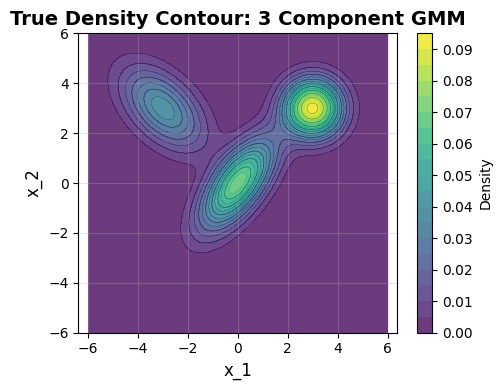

In [5]:
# Plotting the true density contour
plt.figure(figsize=(5, 4))
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Density')
plt.contour(X, Y, Z, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.xlabel('x_1', fontsize=12)
plt.ylabel('x_2', fontsize=12)
plt.title('True Density Contour: 3 Component GMM', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

##### **TASK 2: REJECTION SAMPLING**

In [6]:
def proposal_density(x):
    """
        Proposal Distribution: N(0, sigma^2 * I) with sigma = 2.5
    """
    sigma = 2.5
    proposal_cov = (sigma ** 2) * np.eye(2, dtype=np.float64)
    proposal = multivariate_normal(mean=np.zeros(2, dtype=np.float64), cov=proposal_cov)
    return proposal.pdf(x)

In [7]:
# Envelope constant
c = 12.0
# Target number of accepted samples
N_accept = 10000
# For Rejection Sampling
accepted_samples = []
n_proposed = 0
n_accepted = 0

In [8]:
print(f"Sampling with c = {c}, target: {N_accept} accepted samples.")
while n_accepted < N_accept:
    # Propose a sample from q(x)
    sigma = 2.5
    proposal_cov = (sigma ** 2) * np.eye(2, dtype=np.float64)
    proposal = multivariate_normal(mean=np.zeros(2, dtype=np.float64), cov=proposal_cov)
    x_proposal = proposal.rvs(size=1).astype(np.float64)
    n_proposed += 1
    
    # Compute acceptance probability
    u = np.random.uniform(0, 1)
    acceptance_prob = target_density(x_proposal) / (c * proposal_density(x_proposal))
    
    if u <= acceptance_prob:
        accepted_samples.append(x_proposal)
        n_accepted += 1
    
    if n_proposed % 10000 == 0:
        print(f"Proposed: {n_proposed}, Accepted: {n_accepted}, Rate: {n_accepted/n_proposed:.4f}")

Sampling with c = 12.0, target: 10000 accepted samples.


Proposed: 10000, Accepted: 831, Rate: 0.0831
Proposed: 20000, Accepted: 1651, Rate: 0.0825
Proposed: 30000, Accepted: 2491, Rate: 0.0830
Proposed: 40000, Accepted: 3285, Rate: 0.0821
Proposed: 50000, Accepted: 4068, Rate: 0.0814
Proposed: 60000, Accepted: 4889, Rate: 0.0815
Proposed: 70000, Accepted: 5707, Rate: 0.0815
Proposed: 80000, Accepted: 6518, Rate: 0.0815
Proposed: 90000, Accepted: 7365, Rate: 0.0818
Proposed: 100000, Accepted: 8210, Rate: 0.0821
Proposed: 110000, Accepted: 9070, Rate: 0.0825
Proposed: 120000, Accepted: 9888, Rate: 0.0824


In [9]:
accepted_samples = np.array(accepted_samples).squeeze()
acceptance_rate = n_accepted / n_proposed
print(f"Total proposed: {n_proposed}, Total accepted: {n_accepted}, Final acceptance rate: {acceptance_rate:.4f}")

Total proposed: 121323, Total accepted: 10000, Final acceptance rate: 0.0824


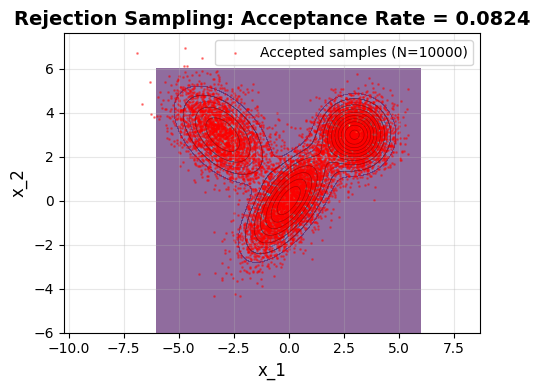

In [10]:
plt.figure(figsize=(5, 4))
plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
plt.contour(X, Y, Z, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.scatter(accepted_samples[:, 0], accepted_samples[:, 1], c='red', s=1, alpha=0.4, label=f'Accepted samples (N={N_accept})')
plt.xlabel('x_1', fontsize=12)
plt.ylabel('x_2', fontsize=12)
plt.title(f'Rejection Sampling: Acceptance Rate = {acceptance_rate:.4f}', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

##### **TASK 3: IMPORTANCE SAMPLING**

In [11]:
N_importance = 50000
sigma = 2.5
proposal_cov = (sigma ** 2) * np.eye(2, dtype=np.float64)
proposal = multivariate_normal(mean=np.zeros(2, dtype=np.float64), cov=proposal_cov)
samples = proposal.rvs(size=N_importance).astype(np.float64)
weights_importance = target_density(samples) / proposal_density(samples)
weights_normalized = weights_importance / np.sum(weights_importance)

In [12]:
def test_function(x):
    return x[:, 0]**2 + np.sin(x[:, 1])
f_values = test_function(samples)
estimated_mean = np.sum(weights_normalized * f_values)
weighted_variance = np.sum(weights_normalized * (f_values - estimated_mean)**2)
ESS = (np.sum(weights_importance)**2) / np.sum(weights_importance**2)

In [13]:
print(f"Importance sampling with {N_importance} samples")
print(f"Results for f(x) = x_1^2 + sin(x_2)")
print(f"Estimated mean: {estimated_mean:.6f}")
print(f"Weighted variance: {weighted_variance:.6f}")
print(f"Effective Sample Size (ESS): {ESS:.2f}")

Importance sampling with 50000 samples
Results for f(x) = x_1^2 + sin(x_2)
Estimated mean: 6.382037
Weighted variance: 39.018969
Effective Sample Size (ESS): 10367.54


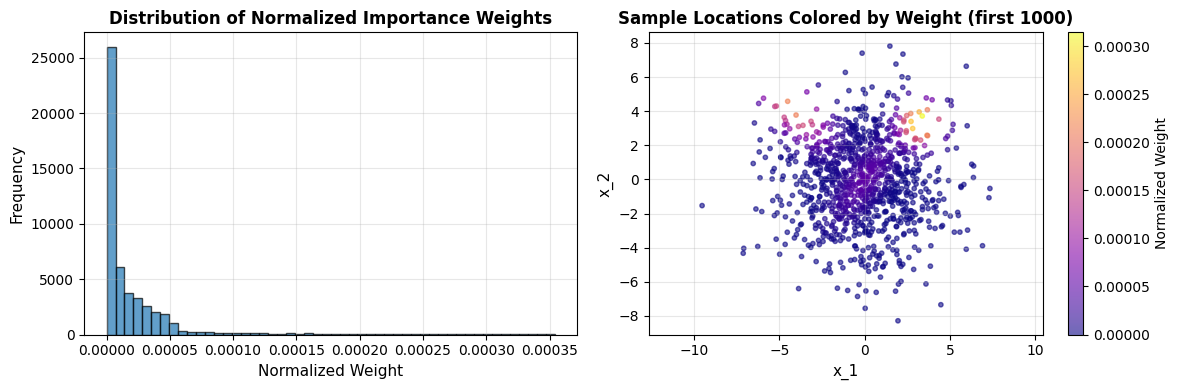

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(weights_normalized, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Normalized Weight', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Normalized Importance Weights', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(samples[:1000, 0], samples[:1000, 1], c=weights_normalized[:1000], s=10, cmap='plasma', alpha=0.6)
plt.colorbar(label='Normalized Weight')
plt.xlabel('x_1', fontsize=11)
plt.ylabel('x_2', fontsize=11)
plt.title('Sample Locations Colored by Weight (first 1000)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

##### **TASK 4: METROPOLIS-HASTINGS SAMPLING**

In [15]:
def metropolis_hastings(target_density, step_size, n_iters, x0, burn_in, thin):
    """
        Metropolis Hastings with random walk proposal
        Args:
            target_density: target density function
            step_size: standard deviation for random walk proposal
            n_iters: total number of iterations
            x0: initial state
            burn_in: number of initial (burn-in) samples to discard
            thin: thinning factor
        Returns:
            samples: array of samples after burn-in and thinning
            acceptance_rate: fraction of accepted proposals
    """
    x = x0.copy()
    samples = [x.copy()]
    n_accepted = 0
    for i in range(1, n_iters):
        x_proposed = x + np.random.normal(0, step_size, size=2).astype(np.float64)
        p_curr = target_density(x)
        p_prop = target_density(x_proposed)
        
        if p_curr > 0:
            alpha = min(1.0, p_prop / p_curr)
        else:
            alpha = 1.0
            
        if np.random.uniform() < alpha:
            x = x_proposed
            n_accepted += 1
            
        samples.append(x.copy())
        
    samples = np.array(samples)
    samples_final = samples[burn_in::thin]
    acceptance_rate = n_accepted / n_iters
    
    return samples_final, acceptance_rate, samples

In [16]:
step_sizes = [0.1, 0.5, 1.5]
n_iters = 50000
x0 = np.array([0.0, 0.0], dtype=np.float64)
burn_in = 5000
thin = 5
results_mh = {}

In [17]:
for s in step_sizes:
    print(f"Running Metropolis-Hastings with step size (s): {s}")
    samples_final, acceptance_rate, all_samples = metropolis_hastings(target_density, s, n_iters, x0, burn_in, thin)
    results_mh[s] = {
        'samples': samples_final,
        'acceptance_rate': acceptance_rate,
        'all_samples': all_samples
    }
    print(f"Acceptance Rate: {acceptance_rate:.4f}")
    print(f"Final Sample Count: {len(samples_final)}")

Running Metropolis-Hastings with step size (s): 0.1
Acceptance Rate: 0.9427
Final Sample Count: 9000
Running Metropolis-Hastings with step size (s): 0.5
Acceptance Rate: 0.7386
Final Sample Count: 9000
Running Metropolis-Hastings with step size (s): 1.5
Acceptance Rate: 0.4116
Final Sample Count: 9000


In [18]:
# Plotting and Analysis for s = 0.5
s_analyze = 0.5
samples_analyze = results_mh[s_analyze]['samples']
all_samples_analyze = results_mh[s_analyze]['all_samples']
acceptance_rate_analyze = results_mh[s_analyze]['acceptance_rate']

In [19]:
def compute_acf(x, max_lag):
    """
        Compute autocorrelation function up to max_lag
    """
    mean = np.mean(x)
    var = np.var(x)
    acf = np.zeros(max_lag + 1)
    n = len(x)
    for k in range(max_lag + 1):
        if k == 0:
            acf[k] = 1.0
        else:
            acf[k] = np.mean((x[:n-k] - mean) * (x[k:] - mean)) / var
    return acf

In [20]:
max_lag = 50
acf_x1 = compute_acf(samples_analyze[:, 0], max_lag)

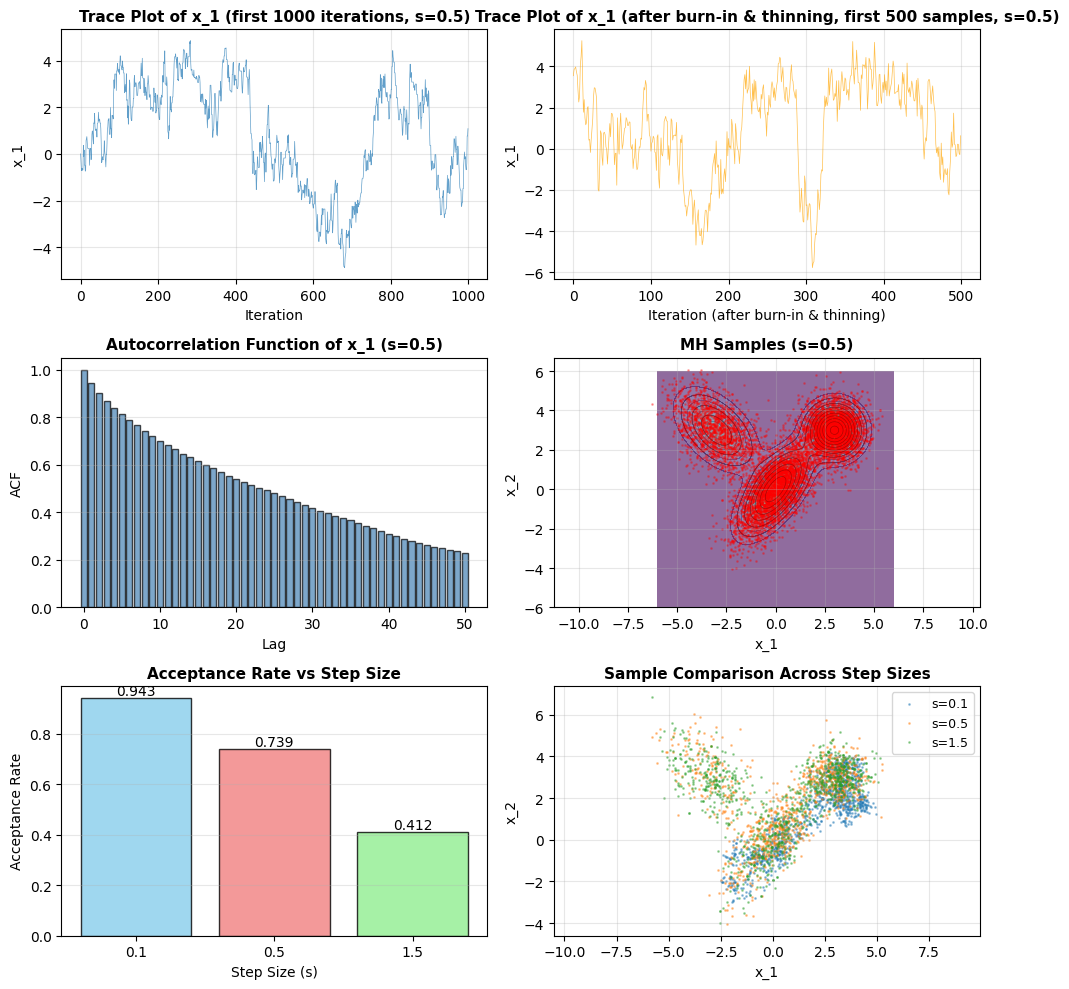

In [21]:
fig = plt.figure(figsize=(10, 10))

# Trace plot for x1
ax1 = plt.subplot(3, 2, 1)
plt.plot(all_samples_analyze[:1000, 0], linewidth=0.5, alpha=0.7)
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('x_1', fontsize=10)
plt.title(f'Trace Plot of x_1 (first 1000 iterations, s={s_analyze})', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Trace plot after burn-in and thinning
ax2 = plt.subplot(3, 2, 2)
plt.plot(samples_analyze[:500, 0], linewidth=0.5, alpha=0.7, color='orange')
plt.xlabel('Iteration (after burn-in & thinning)', fontsize=10)
plt.ylabel('x_1', fontsize=10)
plt.title(f'Trace Plot of x_1 (after burn-in & thinning, first 500 samples, s={s_analyze})', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# ACF plot
ax3 = plt.subplot(3, 2, 3)
plt.bar(range(max_lag + 1), acf_x1, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('Lag', fontsize=10)
plt.ylabel('ACF', fontsize=10)
plt.title(f'Autocorrelation Function of x_1 (s={s_analyze})', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Samples overlaid on contour
ax4 = plt.subplot(3, 2, 4)
plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
plt.contour(X, Y, Z, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.scatter(samples_analyze[:, 0], samples_analyze[:, 1], 
            c='red', s=1, alpha=0.3)
plt.xlabel('x_1', fontsize=10)
plt.ylabel('x_2', fontsize=10)
plt.title(f'MH Samples (s={s_analyze})', fontsize=11, fontweight='bold')
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Acceptance rates
ax5 = plt.subplot(3, 2, 5)
acc_rates = [results_mh[s]['acceptance_rate'] for s in step_sizes]
bars = plt.bar([str(s) for s in step_sizes], acc_rates, 
               color=['skyblue', 'lightcoral', 'lightgreen'], 
               edgecolor='black', alpha=0.8)
for bar, rate in zip(bars, acc_rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.3f}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Step Size (s)', fontsize=10)
plt.ylabel('Acceptance Rate', fontsize=10)
plt.title('Acceptance Rate vs Step Size', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Sample distributions for different step sizes
ax6 = plt.subplot(3, 2, 6)
for s in step_sizes:
    samples = results_mh[s]['samples']
    plt.scatter(samples[:1000, 0], samples[:1000, 1], 
                s=1, alpha=0.4, label=f's={s}')
plt.xlabel('x_1', fontsize=10)
plt.ylabel('x_2', fontsize=10)
plt.title('Sample Comparison Across Step Sizes', fontsize=11, fontweight='bold')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [22]:
print(f"Acceptance Rates:")
for s in step_sizes:
    print(f"s = {s}: {results_mh[s]['acceptance_rate']:.4f}")

Acceptance Rates:
s = 0.1: 0.9427
s = 0.5: 0.7386
s = 1.5: 0.4116


In [ ]:
# As we can observe, that as the step size increases, the acceptance rate decreases.
# So a moderate step size is preferred for better mixing.

##### **TASK 5: GIBBS SAMPLING**

In [23]:
# x ~ Gaussian target mu = [0, 0], cov = [[1, 0.9], [0.9, 1]]
# Conditional 1: x1 | x2 ~ N(0.9x2, 1 - 0.9^2
# Conditional 2: x2 | x1 ~ N(0.9x1, 1 - 0.9^2)
mu_gibbs = np.array([0.0, 0.0], dtype=np.float64)
sigma_gibbs = np.array([[1.0, 0.9], [0.9, 1.0]], dtype=np.float64)

In [24]:
def gibbs_sampling(n_iters, x0, burn_in, thin):
    """
        Gibbs Sampling for bivariate Gaussian
        Args:
            n_iters: total number of iterations
            x0: initial state
            burn_in: number of initial (burn-in) samples
            thin: thinning factor
        Returns:
            samples: array of samples after burn-in and thinning
    """
    x = x0.copy().astype(np.float64)
    samples = [x.copy()]
    
    for i in range(1, n_iters):
        # sample from conditional distribution 1
        mean_x1 = 0.9 * x[1]
        x[0] = np.float64(np.random.normal(mean_x1, np.sqrt(1 - 0.9**2)))
        
        # sample from conditional distribution 2
        mean_x2 = 0.9 * x[0]
        x[1] = np.float64(np.random.normal(mean_x2, np.sqrt(1 - 0.9**2)))
        
        samples.append(x.copy())
        
    samples = np.array(samples)
    samples_final = samples[burn_in::thin]
    return samples_final, samples

In [25]:
n_iters_gibbs = 50000
x0_gibbs = np.array([0.0, 0.0], dtype=np.float64)
burn_in_gibbs = 5000
thin_gibbs = 5
print("Running Gibbs Sampling...")
samples_gibbs, all_samples_gibbs = gibbs_sampling(n_iters_gibbs, x0_gibbs, burn_in_gibbs, thin_gibbs)
print(f"Gibbs Sampling completed. Final sample count: {len(samples_gibbs)}")

Running Gibbs Sampling...
Gibbs Sampling completed. Final sample count: 9000


In [26]:
acf_gibbs_x1 = compute_acf(samples_gibbs[:, 0], max_lag)
X_gibbs, Y_gibbs = X, Y
Z_gibbs = multivariate_normal(mean=mu_gibbs, cov=sigma_gibbs).pdf(np.dstack((X_gibbs, Y_gibbs)).reshape(-1, 2)).reshape(200, 200)

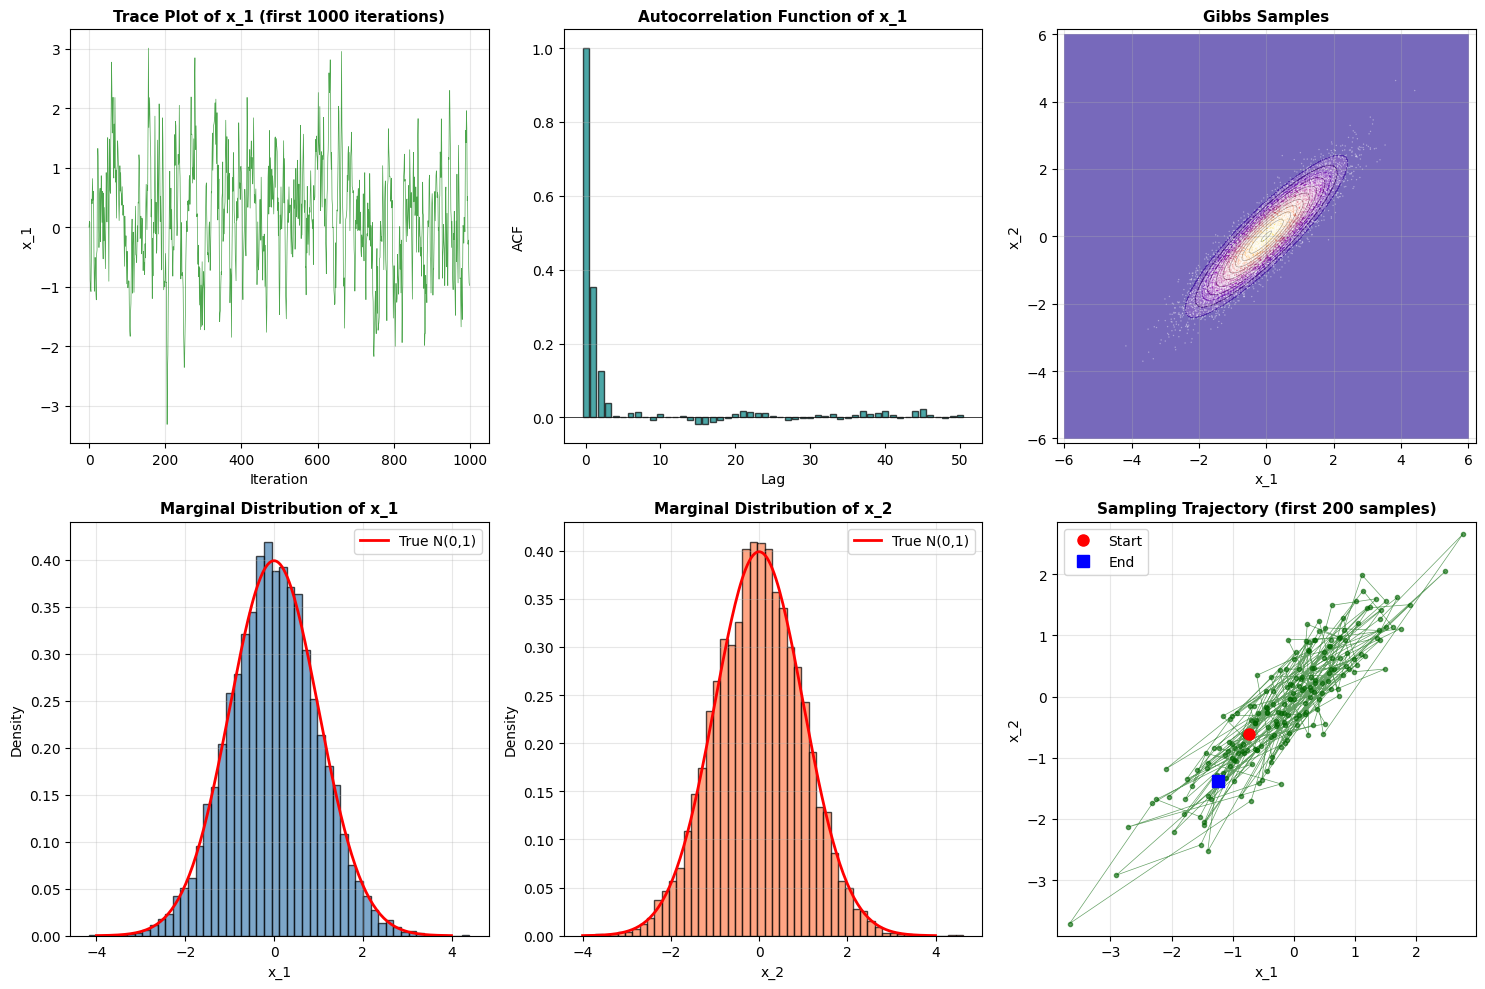

In [27]:
fig = plt.figure(figsize=(15, 10))

# Trace plot for x1
ax1 = plt.subplot(2, 3, 1)
plt.plot(all_samples_gibbs[:1000, 0], linewidth=0.5, alpha=0.7, color='green')
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('x_1', fontsize=10)
plt.title('Trace Plot of x_1 (first 1000 iterations)', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3)

# Autocorrelation plot
ax2 = plt.subplot(2, 3, 2)
plt.bar(range(max_lag + 1), acf_gibbs_x1, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Lag', fontsize=10)
plt.ylabel('ACF', fontsize=10)
plt.title('Autocorrelation Function of x_1', fontsize=11, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Samples scatter
ax3 = plt.subplot(2, 3, 3)
plt.contourf(X_gibbs, Y_gibbs, Z_gibbs, levels=20, cmap='plasma', alpha=0.6)
plt.contour(X_gibbs, Y_gibbs, Z_gibbs, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.scatter(samples_gibbs[:, 0], samples_gibbs[:, 1], 
            c='white', s=1, alpha=0.4, edgecolors='none')
plt.xlabel('x_1', fontsize=10)
plt.ylabel('x_2', fontsize=10)
plt.title(f'Gibbs Samples', fontsize=11, fontweight='bold')
plt.axis('equal')
plt.grid(True, alpha=0.3)

# Marginal histograms
ax4 = plt.subplot(2, 3, 4)
plt.hist(samples_gibbs[:, 0], bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
x_plot = np.linspace(-4, 4, 200)
plt.plot(x_plot, multivariate_normal(0, 1).pdf(x_plot), 'r-', linewidth=2, label='True N(0,1)')
plt.xlabel('x_1', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Marginal Distribution of x_1', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
ax5 = plt.subplot(2, 3, 5)
plt.hist(samples_gibbs[:, 1], bins=50, density=True, alpha=0.7, color='coral', edgecolor='black')
plt.plot(x_plot, multivariate_normal(0, 1).pdf(x_plot), 'r-', linewidth=2, label='True N(0,1)')
plt.xlabel('x_2', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Marginal Distribution of x_2', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Trajectory
ax6 = plt.subplot(2, 3, 6)
n_show = 200
plt.plot(samples_gibbs[:n_show, 0], samples_gibbs[:n_show, 1], 
         'o-', markersize=3, linewidth=0.5, alpha=0.6, color='darkgreen')
plt.plot(samples_gibbs[0, 0], samples_gibbs[0, 1], 'ro', markersize=8, label='Start')
plt.plot(samples_gibbs[n_show-1, 0], samples_gibbs[n_show-1, 1], 'bs', markersize=8, label='End')
plt.xlabel('x_1', fontsize=10)
plt.ylabel('x_2', fontsize=10)
plt.title(f'Sampling Trajectory (first {n_show} samples)', fontsize=11, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

In [28]:
sample_mean = np.mean(samples_gibbs, axis=0)
sample_cov = np.cov(samples_gibbs.T)
sample_corr = sample_cov[0, 1] / (np.sqrt(sample_cov[0, 0]) * np.sqrt(sample_cov[1, 1]))

print("Sample Statistics")
print(f"Sample Mean: [{sample_mean[0]:.4f}, {sample_mean[1]:.4f}]")
print(f"Sample Correlation: {sample_corr:.4f}")
print(f"Sample Covariance Matrix:\n{sample_cov}")

Sample Statistics
Sample Mean: [-0.0179, -0.0223]
Sample Correlation: 0.8977
Sample Covariance Matrix:
[[0.98557944 0.88476528]
 [0.88476528 0.9855869 ]]
